# Clustering arrondissement of Paris by their restaurants

In [73]:
import pandas as pd
import numpy as np
import json
import requests

from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium 

### Data extraction

Obtain the latitude and longitude of each arrondissement

In [23]:
# find the coordinates of a place
def find_coordinates(address):
    geolocator = Nominatim(user_agent="xxx")
    location = geolocator.geocode(address)
    lat = location.latitude
    lon = location.longitude
    return lat, lon

# find the coordinates of Paris
lat_paris, lon_paris = find_coordinates('Paris, Ile-de-France')
print(f'Coords Paris {lat_paris}, {lon_paris}.')

# find the coordinates of each arrondissement
df = pd.DataFrame(columns=['Arrondissement', 'Latitude', 'Longitude'])
for i in range(1, 21):
    arr = '750'
    if i < 10:
        arr += f'0{str(i)}'
    else:
        arr += str(i)
    lat, lon = find_coordinates(f'{arr} Paris, Ile-de-France')
    df.loc[len(df)] = [str(i), lat, lon]
    print(i)

#show the df
df

Coords Paris 48.8762502, 2.324441148366757.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


,Arrondissement,Latitude,Longitude
0,1,48.864671,2.330138
1,2,48.867534,2.343925
2,3,48.864425,2.359444
3,4,48.856137,2.357145
4,5,48.846095,2.348502
5,6,48.852813,2.342799
6,7,48.854757,2.324789
7,8,48.876250,2.324441
8,9,48.875781,2.327347
9,10,48.873690,2.348787


In [24]:
# create map
map_paris = folium.Map(location=[lat_paris, lon_paris], zoom_start=10)

# add markers to the map
for index, row in df.iterrows():
    label = f'Arrondissement {row.Arrondissement}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  

# show the city  
map_paris

Obtain the main venues of each arrondissement

In [26]:
# function to get the venues nearby the arrondissement
def getNearbyVenues(names, latitudes, longitudes):
    radius=1000
    LIMIT=200
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
            
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lon}&radius={radius}&limit={LIMIT}'

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Arrondissement', 
                  'Arrondissement Latitude', 
                  'Arrondissement Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

In [29]:
df_venues = getNearbyVenues(df['Arrondissement'], df['Latitude'], df['Longitude'])
df_venues.head(10)

,Arrondissement,Arrondissement Latitude,Arrondissement Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,48.864671,2.330138,Librairie Galignani,48.864989,2.328570,Bookstore
1,1,48.864671,2.330138,Grand Bassin Rond,48.862880,2.329295,Fountain
2,1,48.864671,2.330138,Balagan,48.865432,2.329680,Israeli Restaurant
3,1,48.864671,2.330138,Le Dalí,48.865333,2.328137,French Restaurant
4,1,48.864671,2.330138,Ladurée,48.866121,2.328449,Dessert Shop
5,1,48.864671,2.330138,Place des Pyramides,48.863924,2.332224,Plaza
6,1,48.864671,2.330138,Balenciaga,48.865927,2.330284,Women's Store
7,1,48.864671,2.330138,Hôtel Le Meurice,48.865333,2.328137,Hotel
8,1,48.864671,2.330138,Angelina,48.865090,2.328443,Tea Room
9,1,48.864671,2.330138,Hôtel Le Pradey,48.864459,2.331654,Hotel


### Data Processing 

Filter the venues to obtain only the restaurants and apply one hot encoder

In [35]:
df_rest = df_venues[df_venues['Venue Category'].str.contains('Restaurant')]
# one hot encoding
onehot = pd.get_dummies(df_rest[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Arrondissement'] = df_rest['Arrondissement'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head(10)

,Arrondissement,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Basque Restaurant,Brazilian Restaurant,Breton Restaurant,Cajun / Creole Restaurant,...,Spanish Restaurant,Sushi Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Get the main types of restaurants and select the top 5 of each arrondissement

In [39]:
df_rest_grouped = onehot.groupby('Arrondissement').mean().reset_index()
n = 10

for arr in df_rest_grouped['Arrondissement']:
    print("----"+arr+"----")
    temp = df_rest_grouped[df_rest_grouped['Arrondissement'] == arr].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(n))
    print('\n')

----1----
                       venue  freq
0        Japanese Restaurant  0.33
1          French Restaurant  0.29
2          Korean Restaurant  0.08
3            Udon Restaurant  0.08
4         Israeli Restaurant  0.04
5    Scandinavian Restaurant  0.04
6         Italian Restaurant  0.04
7         English Restaurant  0.04
8            Thai Restaurant  0.04
9  Middle Eastern Restaurant  0.00


----10----
                           venue  freq
0              French Restaurant  0.29
1            Japanese Restaurant  0.11
2  Vegetarian / Vegan Restaurant  0.08
3                     Restaurant  0.08
4             Italian Restaurant  0.05
5            Corsican Restaurant  0.05
6             African Restaurant  0.03
7            Empanada Restaurant  0.03
8              Korean Restaurant  0.03
9             Israeli Restaurant  0.03


----11----
                    venue  freq
0       French Restaurant  0.43
1      Italian Restaurant  0.12
2              Restaurant  0.07
3   Vietnamese Restaur

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [70]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Arrondissement']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurants_sorted = pd.DataFrame(columns=columns)
restaurants_sorted['Arrondissement'] = df_rest_grouped['Arrondissement']

for ind in np.arange(df_rest_grouped.shape[0]):
    restaurants_sorted.iloc[ind, 1:] = return_most_common_venues(df_rest_grouped.iloc[ind, :], num_top_venues)

restaurants_sorted.head(20)

,Arrondissement,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Japanese Restaurant,French Restaurant,Korean Restaurant,Udon Restaurant,Israeli Restaurant
1,10,French Restaurant,Japanese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Corsican Restaurant
2,11,French Restaurant,Italian Restaurant,Restaurant,Vietnamese Restaurant,Korean Restaurant
3,12,French Restaurant,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant
4,13,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Chinese Restaurant
5,14,French Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Seafood Restaurant
6,15,French Restaurant,Italian Restaurant,Lebanese Restaurant,Thai Restaurant,Indian Restaurant
7,16,French Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant
8,17,French Restaurant,Italian Restaurant,Restaurant,Seafood Restaurant,Mediterranean Restaurant
9,18,French Restaurant,Italian Restaurant,Restaurant,Seafood Restaurant,Japanese Restaurant


### Clustering

Identify the number of clusters

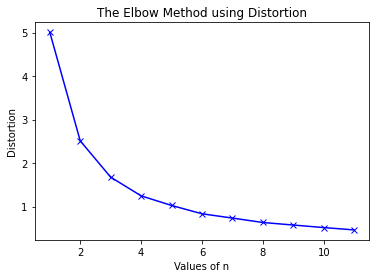

In [55]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 
from sklearn.metrics import silhouette_score


distortions = [] 
inertias = [] 
sil

for i in range(1, 11):
    kmeanModel = KMeans(n_clusters=i, random_state=5).fit(df_rest_grouped)
      
    distortions.append(sum(np.min(cdist(df_rest_grouped, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_rest_grouped.shape[0]) 
    inertias.append(kmeanModel.inertia_) 

plt.plot(range(1,12), distortions, 'bx-') 
plt.xlabel('Values of n') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

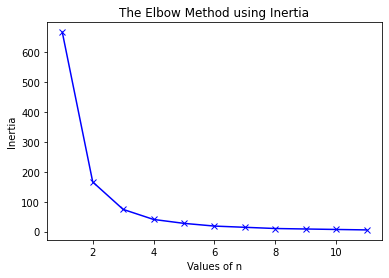

In [57]:
plt.plot(range(1,12), inertias, 'bx-') 
plt.xlabel('Values of n') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Analyzing both graphs, the number of clusters selected is 3.

Clustering with kMeans (n=3)

In [67]:
# set number of clusters
n = 3

df_clustering = df_rest_grouped.drop('Arrondissement', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=n, random_state=0).fit(df_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2],
      dtype=int32)

In [71]:
# add clustering labels
restaurants_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_final = df
df_final = df_final.join(restaurants_sorted.set_index('Arrondissement'), on='Arrondissement')

df_final.head(20)

,Arrondissement,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,48.864671,2.330138,0,Japanese Restaurant,French Restaurant,Korean Restaurant,Udon Restaurant,Israeli Restaurant
1,2,48.867534,2.343925,0,French Restaurant,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Restaurant
2,3,48.864425,2.359444,0,French Restaurant,Restaurant,Italian Restaurant,Vietnamese Restaurant,Seafood Restaurant
3,4,48.856137,2.357145,2,French Restaurant,Restaurant,Scandinavian Restaurant,Tapas Restaurant,Portuguese Restaurant
4,5,48.846095,2.348502,0,French Restaurant,Japanese Restaurant,Greek Restaurant,Italian Restaurant,Lebanese Restaurant
5,6,48.852813,2.342799,2,French Restaurant,Italian Restaurant,Seafood Restaurant,Lebanese Restaurant,Mexican Restaurant
6,7,48.854757,2.324789,2,French Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant,Peruvian Restaurant
7,8,48.876250,2.324441,2,French Restaurant,Italian Restaurant,Thai Restaurant,Vietnamese Restaurant,Lebanese Restaurant
8,9,48.875781,2.327347,2,French Restaurant,Italian Restaurant,Thai Restaurant,Vietnamese Restaurant,Seafood Restaurant
9,10,48.873690,2.348787,0,French Restaurant,Japanese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Corsican Restaurant


In [77]:
# create map
map_clusters = folium.Map(location=[lat_paris, lon_paris], zoom_start=10)

# set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = ['blue', 'red', 'purple']
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Arrondissement'], df_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=markers_colors[cluster-1],
        fill=True,
        fill_color=markers_colors[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 0:

The first and second most common restaurant are French and Japanese. Except in the Arrondissement 3, where the Japanese Restaurant are not so common.
Other characteristic is that the Arrondissements 2, 3 and 4 has Italian Restaurant as the third or fourth most common restaurant.
Also, this Arrondissement has less French participation (less than 40%) that cluster 2.

In [78]:
df_final[df_final['Cluster Labels']==0]

,Arrondissement,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,48.864671,2.330138,0,Japanese Restaurant,French Restaurant,Korean Restaurant,Udon Restaurant,Israeli Restaurant
1,2,48.867534,2.343925,0,French Restaurant,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Restaurant
2,3,48.864425,2.359444,0,French Restaurant,Restaurant,Italian Restaurant,Vietnamese Restaurant,Seafood Restaurant
4,5,48.846095,2.348502,0,French Restaurant,Japanese Restaurant,Greek Restaurant,Italian Restaurant,Lebanese Restaurant
9,10,48.873690,2.348787,0,French Restaurant,Japanese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Corsican Restaurant


Cluster 1:

It has only one Arrondissement, the 13. This Arrondissement may be classify as Asian, because it has plenty of restaurants from this continent. Unlike the other clusters the French participation is smaller (near 10%)

In [79]:
df_final[df_final['Cluster Labels']==1]

,Arrondissement,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,13,48.829351,2.362052,1,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Chinese Restaurant


Cluster 2:

This is the bigger cluster. The first and second most common restaurant are French and Italian.
Other common restaurants are Seafood, Thai, Vietnamese and Japanese.

In [80]:
df_final[df_final['Cluster Labels']==2]

,Arrondissement,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,4,48.856137,2.357145,2,French Restaurant,Restaurant,Scandinavian Restaurant,Tapas Restaurant,Portuguese Restaurant
5,6,48.852813,2.342799,2,French Restaurant,Italian Restaurant,Seafood Restaurant,Lebanese Restaurant,Mexican Restaurant
6,7,48.854757,2.324789,2,French Restaurant,Italian Restaurant,American Restaurant,Japanese Restaurant,Peruvian Restaurant
7,8,48.876250,2.324441,2,French Restaurant,Italian Restaurant,Thai Restaurant,Vietnamese Restaurant,Lebanese Restaurant
8,9,48.875781,2.327347,2,French Restaurant,Italian Restaurant,Thai Restaurant,Vietnamese Restaurant,Seafood Restaurant
10,11,48.850298,2.384783,2,French Restaurant,Italian Restaurant,Restaurant,Vietnamese Restaurant,Korean Restaurant
11,12,48.843369,2.386362,2,French Restaurant,Italian Restaurant,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant
13,14,48.830851,2.325746,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Seafood Restaurant
14,15,48.838435,2.294916,2,French Restaurant,Italian Restaurant,Lebanese Restaurant,Thai Restaurant,Indian Restaurant
15,16,48.852952,2.272285,2,French Restaurant,Italian Restaurant,Japanese Restaurant,Thai Restaurant,Middle Eastern Restaurant
